In [2]:
# grep -i "gw01.extranet.frachtwerk.de filterlog" pfsense.log > pfsense.csv
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns', None)


In [3]:
# Full parquet needs to be build
# df = pd.read_parquet('./data/df_v4.parquet', engine='pyarrow') 
df = pd.read_parquet('./data/df_v4_10000', engine='pyarrow') 

In [5]:
df.replace(r'^\s*$', np.nan, regex=True, inplace=True) 

In [62]:
df.dropna(how='all', axis=1, inplace=True) 

In [63]:
# Output of information about the data frame
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15320506 entries, 0 to 15320505
Data columns (total 27 columns):
date_time            object
rule_number          object
tracker_id           object
real_interface       object
reason               object
action               object
traffic_direction    object
ip_version           object
tos                  object
ecn                  object
ttl                  object
ipv4_id              object
offset               int64
flags                object
protocoll_id         object
protocoll_text       object
length               int64
source_ip            object
destination_ip       object
source_port          object
destination_port     object
data_length          float64
tcp_flag             object
sequence_num         object
ack                  object
window               object
options              object
dtypes: float64(1), int64(2), object(24)
memory usage: 3.1+ GB


In [64]:
def parse_dtype(df, dtypes):
    for col in dtypes.keys():
        df[col] = df[col].astype(dtypes[col])
    return df

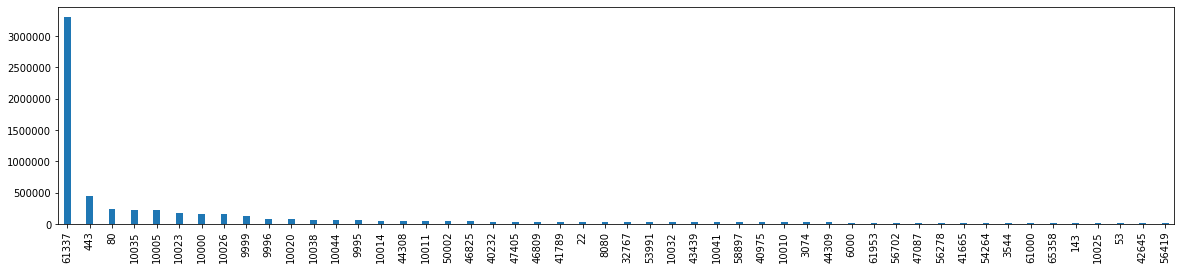

In [4]:
# Output: number of values from column source_port
countedvalues_sourceport = df["source_port"].value_counts()[:50]
countedvalues_sourceport.plot(kind='bar',figsize=(20,4), width=0.3)
# print (countedvalues_sourceport)

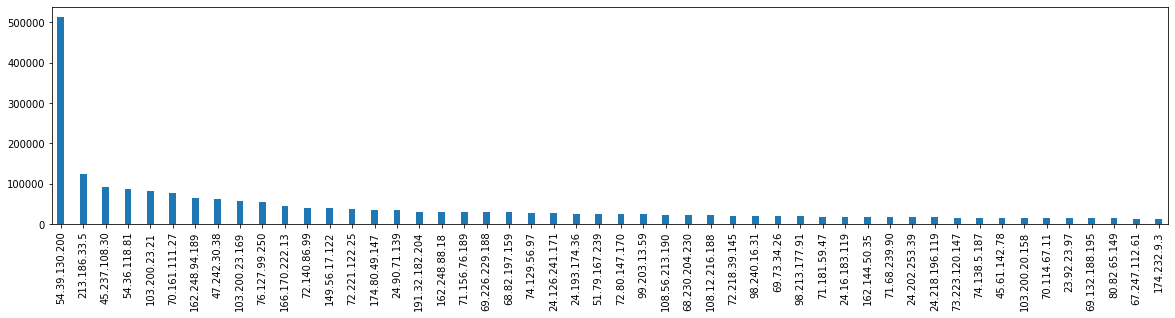

In [9]:
source_ip_addresses_with_port = df[df['source_port'] == '61337']
source_ip_addresses_with_port['source_ip'].value_counts()[:50].plot(kind='bar',figsize=(20,4), width=0.3)

# Shodan.io statistics 54.39.130.200
- City	Victoria
- Country	Canada
- Organization	OVH SAS
- ISP	OVH SAS
- Last Update	2021-01-25T03:33:58.088311
- Hostnames	firewallroozservers.bairesrp.net
- ASN	AS16276


# Shodan.io statistics 213.186.33.5
- Country	France
- Organization	OVH SAS
- ISP	OVH SAS
- Last Update	2021-01-26T16:55:14.534632
- Hostnames	redirect.ovh.net
- ASN	AS16276

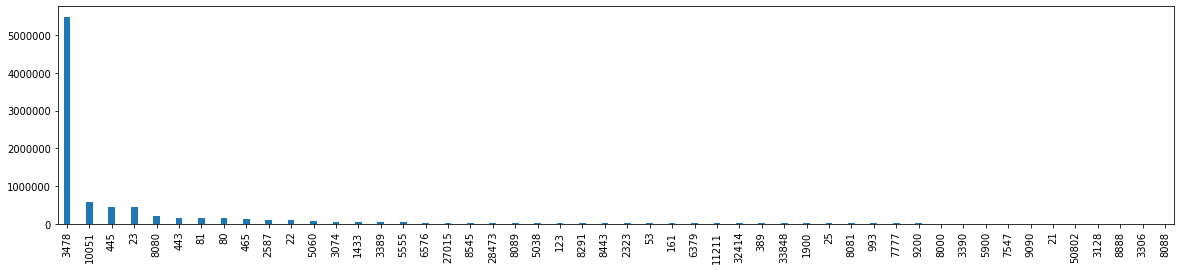

In [10]:
# Output: number of values from column destination_port
countedvalues_destinationport = df["destination_port"].value_counts()[:50]
countedvalues_destinationport.plot(kind='bar',figsize=(20,4), width=0.3)

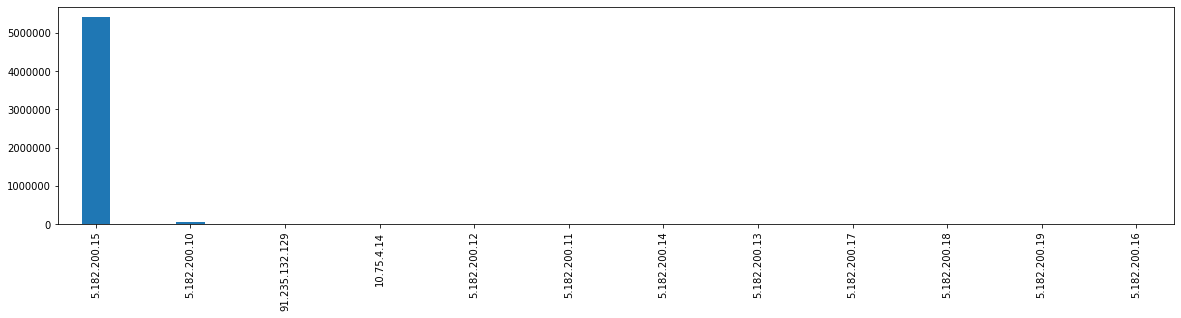

In [11]:
destination_ip_addresses_with_port = df[df['destination_port'] == '3478']
destination_ip_addresses_with_port['destination_ip'].value_counts()[:50].plot(kind='bar',figsize=(20,4), width=0.3)

In [44]:
list_to_remove=[]
for i in df.index:
    try:
        float(df.loc[i,"source_port"])
    except:
        list_to_remove=list_to_remove+[df.loc[i,'source_port']]
        df.drop(i, inplace=True)
print(list_to_remove)

['request', 'request', 'request', 'datalength=32 ', 'request', 'datalength=32 ', 'request', 'request', 'datalength=32 ', 'datalength=544 ', 'request', 'request', 'request', 'request', 'datalength=544 ', 'request', 'request', 'request', 'datalength=32 ', 'request', 'datalength=558 ', 'request', 'request', 'datalength=544 ', 'request', 'datalength=32 ', 'datalength=544 ', 'request', 'request', 'datalength=32 ', 'redirect', 'datalength=32 ', 'request', 'request', 'request', 'datalength=32 ', 'request', 'request', 'request', 'request', 'request', 'datalength=544 ', 'request', 'request', 'request', 'redirect', 'request', 'request', 'request', 'unreach', 'datalength=32 ']


In [45]:
list_to_remove=[]
for i in df.index:
    try:
        float(df.loc[i,"destination_port"])
    except:
        list_to_remove=list_to_remove+[df.loc[i,'destination_port']]
        df.drop(i, inplace=True)
print(list_to_remove)

[]


In [46]:
# Sort by Standard (Well-known)/Registered/Private Ports for Source_Port and Destination_Port
#df['Port_Type_source_port']
for columnnames in ["source_port","destination_port"] :
    df["Port Type_"+ str(columnnames)] = 0
    df.loc[(df[columnnames].astype("float") > 0) & (df[columnnames].astype("float") <1024), "Port Type_"+ str(columnnames)]="standard-port"
    df.loc[(df[columnnames].astype("float") > 1023) & (df[columnnames].astype("float") <49152), "Port Type_"+ str(columnnames)]="registered-port"
    df.loc[(df[columnnames].astype("float") > 49151), "Port Type_"+ str(columnnames)]="private-port"
    
        

In [47]:
# Number of port types is counted and plotted
countedporttype_sourceport = df["Port Type_source_port"].value_counts()
print (countedporttype_sourceport)

private-port       48768
registered-port    45716
standard-port       5464
0                      1
Name: Port Type_source_port, dtype: int64


In [48]:
# Number of port types is counted and plotted
countedporttype_destinationport = df["Port Type_destination_port"].value_counts()
print (countedporttype_destinationport)

registered-port    80417
standard-port      13466
private-port        6064
0                      2
Name: Port Type_destination_port, dtype: int64


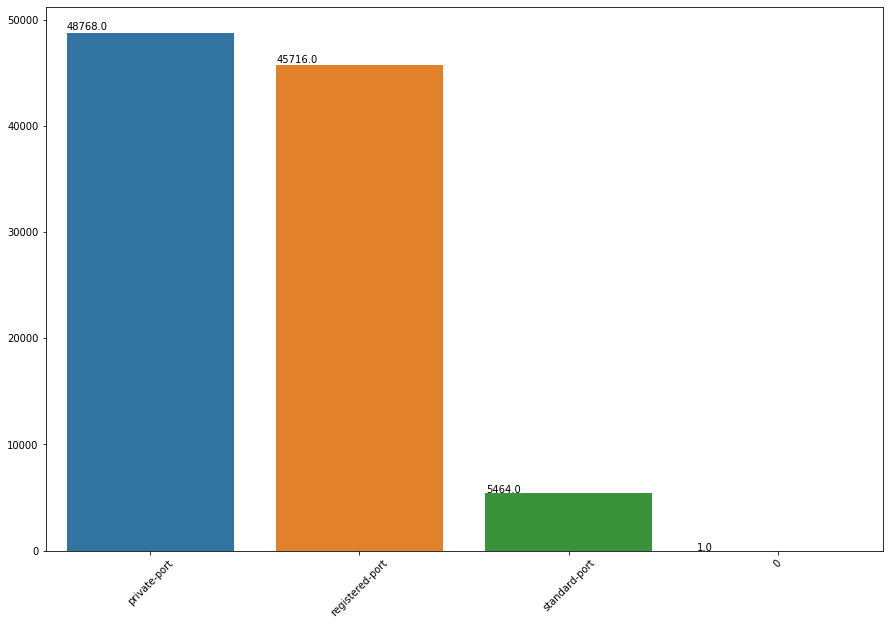

In [49]:
# Bar chart to plot types at source_port
fig, ax = plt.subplots(figsize=(15, 10))
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
ax = sns.barplot(x=countedporttype_sourceport.index, y=countedporttype_sourceport.values)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

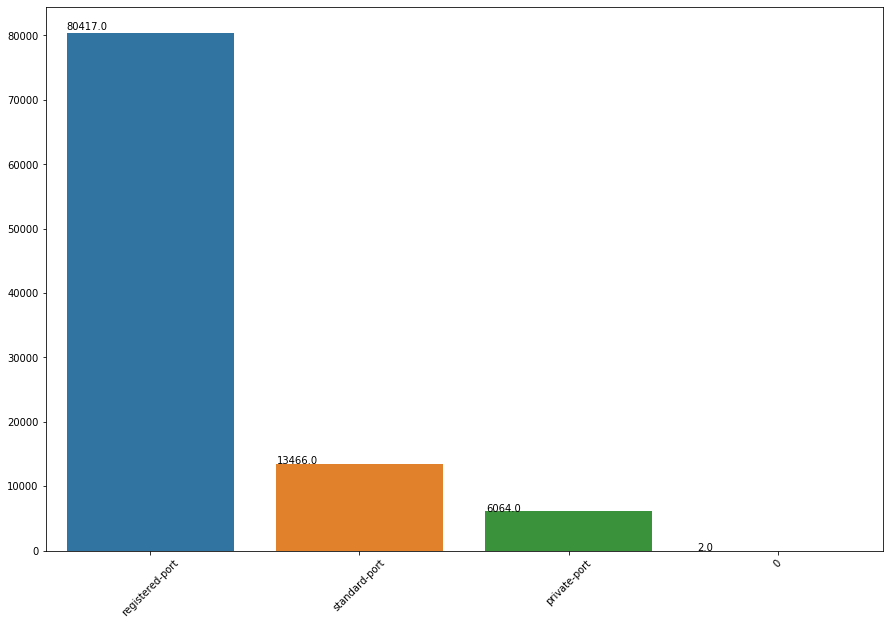

In [50]:
# Bar chart to plot types at destination_port
fig, ax = plt.subplots(figsize=(15, 10))
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
ax = sns.barplot(x=countedporttype_destinationport.index, y=countedporttype_destinationport.values)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

Port Description: e.g.:
* Port Number: 143
* Category: standard
* Service/ Port Name: imap
* Purpose: Internet Message Access Protocol
* Description: Imap protocol is used by eMail clients for the retrieval of their eMail from designated eMail "post office" servers. 
* Protocol: TCP, UDP 
* Source: IANA
* Related Ports: 25, 110, 993
* Virus/Trojan: no

In [51]:
# Columns are added: How often is there which port?
df=df.merge(countedvalues_sourceport, how="left", left_on="source_port", right_index=True, suffixes=('', '_counted'))
df=df.merge(countedvalues_destinationport, how="left", left_on="destination_port", right_index=True, suffixes=('', '_counted'))

In [52]:
# Output of information about the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99949 entries, 0 to 99999
Data columns (total 32 columns):
Unnamed: 0                    99949 non-null int64
date_time                     99949 non-null object
rule_number                   99949 non-null int64
tracker_id                    99949 non-null int64
real_interface                99949 non-null object
reason                        99949 non-null object
action                        99949 non-null object
traffic_direction             99949 non-null object
ip_version                    99949 non-null int64
tos                           99949 non-null object
ecn                           205 non-null object
ttl                           99949 non-null int64
ipv4_id                       99949 non-null int64
offset                        99949 non-null float64
flags                         99949 non-null object
protocoll_id                  99949 non-null int64
protocoll_text                99949 non-null object
length         

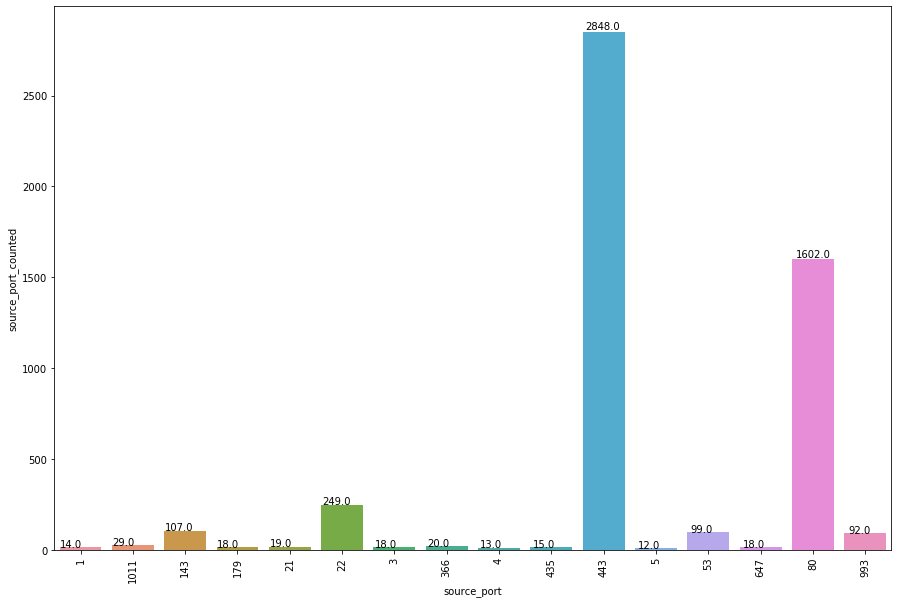

In [58]:
# Bar chart for the number of standard_source_ports
fig, ax = plt.subplots(figsize=(15, 10))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = sns.barplot(x="source_port", y="source_port_counted", data= df.loc[(df["Port Type_source_port"]=="standard-port") & (df["source_port_counted"]>10)])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Noticeable standard source ports:

443: Port 443 is the standard port for all secured HTTP traffic, meaning it’s absolutely essential for most modern web activity. Encryption is necessary to protect information, as it makes its way between your computer and a web server. Port 443 also enables websites to be available over both HTTP and HTTPS. Most websites are configured to work with HTTPS over port 443, but if it isn’t available for some reason, the website will still be live over HTTPS on port 80.

80: Port 80 is the port number assigned to commonly used internet communication protocol, Hypertext Transfer Protocol (HTTP). It is the port from which a computer sends and receives Web client-based communication and messages from a Web server and is used to send and receive HTML pages or data.

993: TCP, Internet Message Access Protocol over TLS/SSL (IMAPS)

22: The port is used for Secure Shell (SSH) communication and allows remote administration access to the VM. In general, traffic is encrypted using password authentication.

143: Imap on port 143 is the newer of the two popular protocols used to retrieve eMail from remote mail servers. (The older protocol, pop3, the Post Office Protocol, uses port 110.) End-user eMail clients send eMail to remote eMail servers using the SMTP protocol on port 25, and typically retrieve their eMail using either pop3 or imap. Email clients and servers must each support both an eMail sending (SMTP) and retrieving (pop3 or imap) protocol.


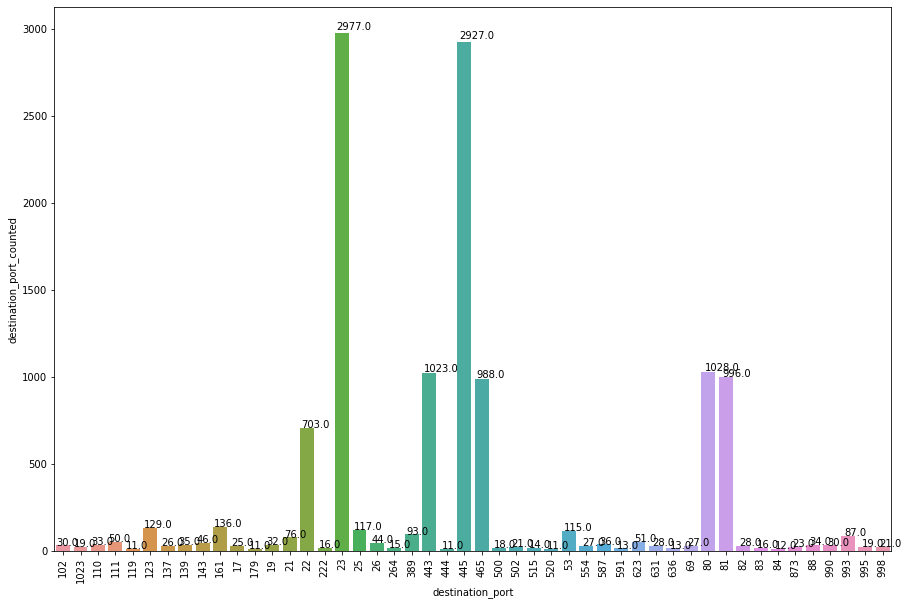

In [25]:
# Bar chart for the number of standard_destination_ports
fig, ax = plt.subplots(figsize=(15, 10))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = sns.barplot(x="destination_port", y="destination_port_counted", data=df.loc[(df["Port Type_destination_port"]=="standard-port") & (df["destination_port_counted"]>10)])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Noticeable standard destination ports:

23: TCP/UDP, telnet/threat/trojan
* Telnet is one of the oldest Internet protocols and the most popular program for remote access to Unix machines. It has numerous security vulnerabilities. Trojans that also use this port: ADM worm, Aphex's Remote Packet Sniffer , AutoSpY, ButtMan, Fire HacKer, My Very Own trojan, Pest, RTB 666, Tiny Telnet Server - TTS, Truva Atl,...

445: TCP, microsoft-ds, used for direct TCP/IP MS Networking access without the need for a NetBIOS layer 

443: Port 443 is the standard port for all secured HTTP traffic, meaning it’s absolutely essential for most modern web activity. Encryption is necessary to protect information, as it makes its way between your computer and a web server. Port 443 also enables websites to be available over both HTTP and HTTPS. Most websites are configured to work with HTTPS over port 443, but if it isn’t available for some reason, the website will still be live over HTTPS on port 80.

80: Port 80 is the port number assigned to commonly used internet communication protocol, Hypertext Transfer Protocol (HTTP). It is the port from which a computer sends and receives Web client-based communication and messages from a Web server and is used to send and receive HTML pages or data.

465: TCP (smtp-ssl, Outgoing SMTP Mail over SSL)/ UDP (igmpv3lite, Cisco IOS 15.2S allows remote attackers to cause a denial of service (interface queue wedge) via malformed UDP traffic on port 465)

81: TCP, http/trojan/threat


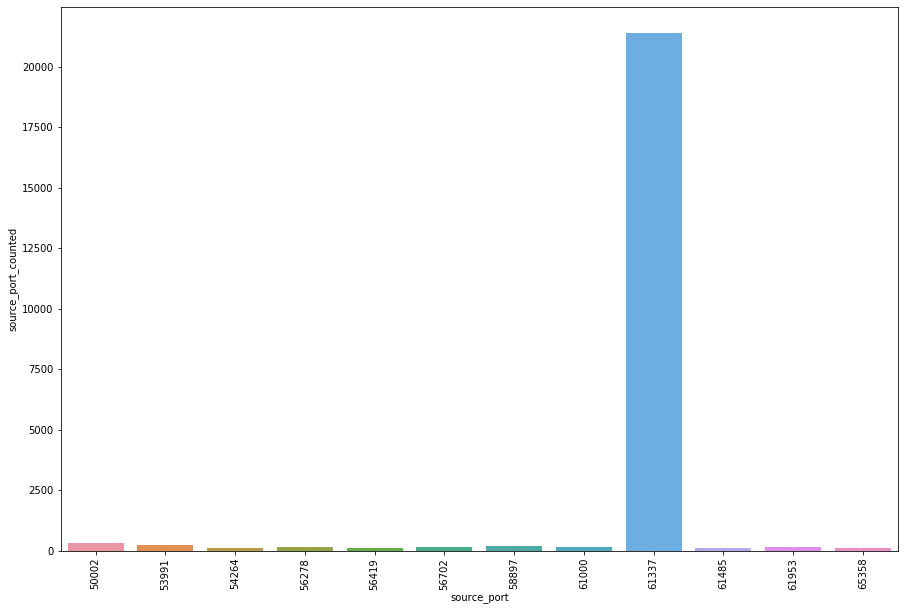

In [66]:
# Bar chart for the number of private_source_ports
fig, ax = plt.subplots(figsize=(15, 10))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = sns.barplot(x="source_port", y="source_port_counted", data=df.loc[(df["Port Type_source_port"]=="private-port") & (df["source_port_counted"]>100)])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Noticeable private source ports:

61337: tcp, trojan


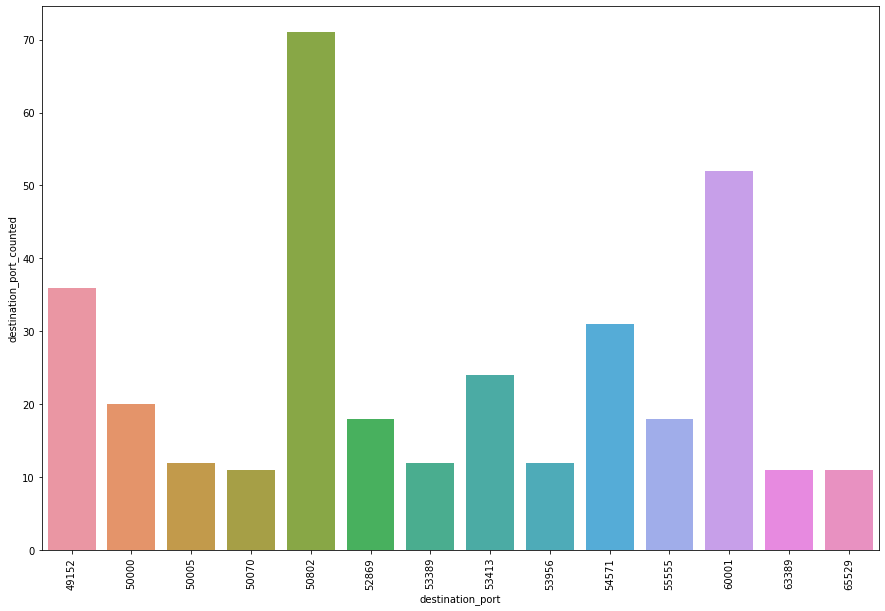

In [70]:
# Bar chart for the number of private_destination_ports
fig, ax = plt.subplots(figsize=(15, 10))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = sns.barplot(x="destination_port", y="destination_port_counted", data=df.loc[(df["Port Type_destination_port"]=="private-port") & (df["destination_port_counted"]>10)])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Noticeable private destination ports:

50802: TCP, Xsan Filesystem Access (Apple)

60001: TCP, Malware known as Trinity, trojan

49152: As the first port in the dynamic/private range (49152-65535), this port is commonly used by applications that utilize a dynamic/random/configurable port.

54571: TCP, Xsan Filesystem Access (Apple)

53413: TCP, Xsan Filesystem Access (Apple)

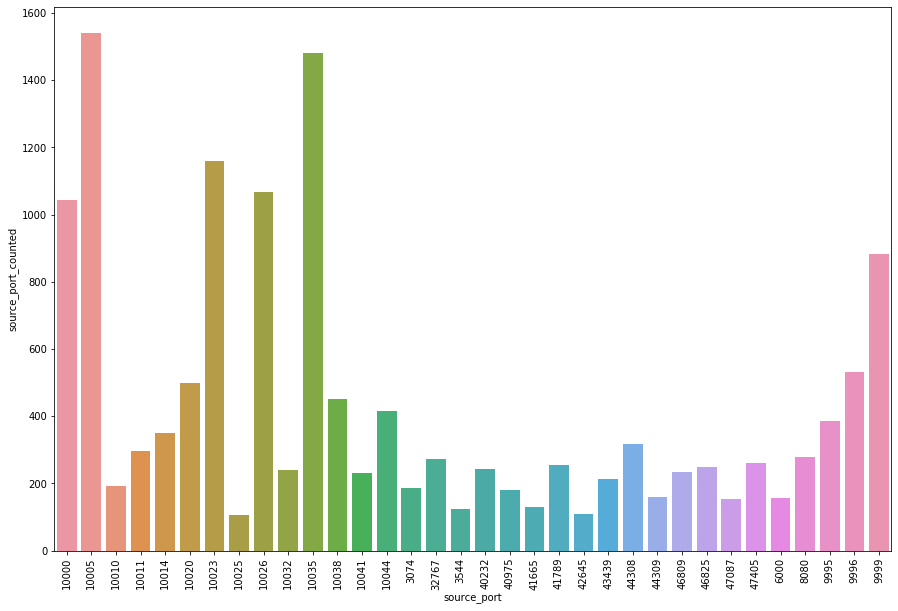

In [72]:
# Bar chart for the number of registered_source_ports
fig, ax = plt.subplots(figsize=(15, 10))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = sns.barplot(x="source_port", y="source_port_counted", data=df.loc[(df["Port Type_source_port"]=="registered-port") & (df["source_port_counted"]>100)])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Noticeable registered source ports:

10005: TCP, OpwinTRojan/ Secure telnet

10035: not applicable or currently an unassigned port number. For unassigned ports, the port number may be available for assignment upon requesting assignment by IANA.

10023: not applicable or currently an unassigned port number. For unassigned ports, the port number may be available for assignment upon requesting assignment by IANA.

10000: TCP, multiple services e.g ndmp (Network Data Management Protocol)

10026: not applicable or currently an unassigned port number. For unassigned ports, the port number may be available for assignment upon requesting assignment by IANA.

9999: TP-Link Smart Outlet remote console access/trojan/threat ???



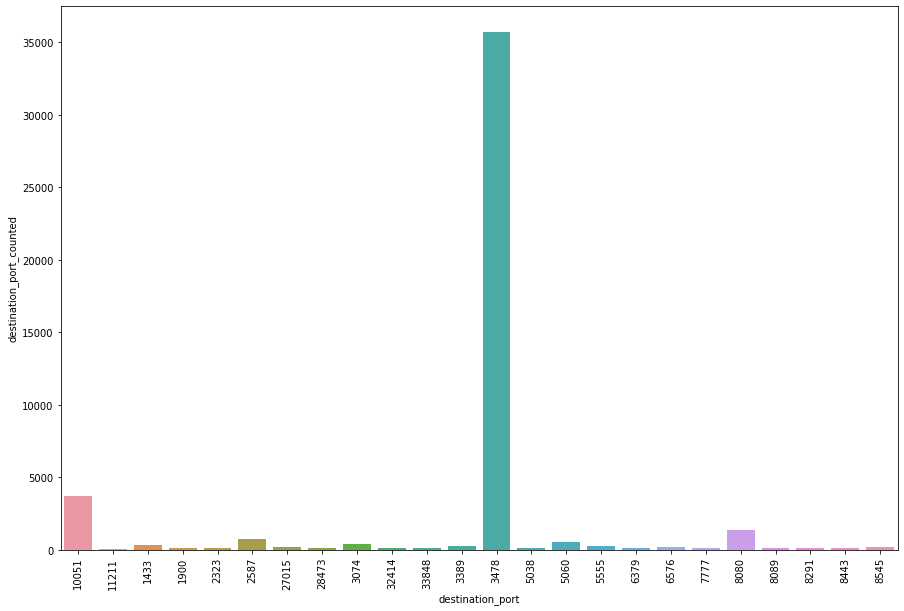

In [74]:
# Bar chart for the number of registered_destination_ports
fig, ax = plt.subplots(figsize=(15, 10))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = sns.barplot(x="destination_port", y="destination_port_counted", data=df.loc[(df["Port Type_destination_port"]=="registered-port") & (df["destination_port_counted"]>100)])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Noticeable registered destination ports:

3478: TCP/UDP, VoIP STUN (Session Traversal Utilities for NAT) port

10051: TCP/UDP, Zabbix-Trapper

8080: Common alternative HTTP port used for web traffic. 


# Documentation

* Network port is an address that can be used to clearly assign UDP or TCP connections to specific applications. A connection has one port on each side. Ports can have a consecutive number in the range from 0 to 65535. Together with the IP address, the network port forms the complete address of an application on a target or sender system.
* TCP (Transmission Control Protocol) is one of the central protocols of the TCP/IP protocol family. It uses the functions of the IP at the switching level, ensures secure end-to-end connections between the communication partners and addresses the applications at higher levels via ports. The source and destination port numbers each specify the application/service and are used to specify the application or services offered on local or remote hosts. A host always specifies a Destination and Source port number for TCP/UDP data communication.
* UDP (User Datagram Protocols) is built on top of IP. In contrast to TCP, it is a connectionless, unsecured protocol. The central functions are the transport of data and the multiplexing of connections.
* The Source_Port is used by the sending host to keep track of new incoming connections and existing data streams.
* The Destination_Port allows the service it requires to be selected.

Websites used for port description:
- https://de.adminsub.net/tcp-udp-port-finder/
- https://www.speedguide.net/